# How to quickly create a workflow from a set of executables

**Please note, this notebook depends on successful execution of the first notebook `1-aiida-intro.ipynb`!**

To run the following Python cells, we need to make sure that we select the correct kernel `Python3.10 (AIIDA)`. If it is
not already selected, do so as follows:

<img src="../../data/figs/change_notebook_kernel.png" width="500" style="height:auto; display:block; margin-left:auto; margin-right:auto;">

***

## Concatenating several scripts to one workflow

### The workflow setup

Now that we have a working profile set up, assume we would like to execute a workflow that is composed of the following
steps:

- 1. Create a database that contains some matrices 
- 2. Run a code that achieves matrix diagonalizations and writes the eigenvalues and eigenvectors to files on disk
- 3. Plot the results from the previous steps

For this tutorial, the chosen example serves mainly demonstration purposes. However, to motivate our choices of
tasks, one could imagine the following concrete use cases:

- 1. Query and download atomic structures from a materials database via their API
- 2. Run structure optimizations using Quantum Mechanical codes like QE (these, like many other numerical codes, run
     many matrix diagonalizations)
- 3. Visualize our results for a scientific publication

Note that AiiDA was originally created for materials science applications, so we are aware that the examples reflect
that. If you think of other use cases, feel free to implement them after this tutorial and let us know about them :star: 

Each of the steps of our workflow can be of arbitrary nature, e.g. an executable on your system, a shell script, Python code, etc.

We provide those for the exemplary workflow outlined above as pre-compiled binaries. Their source code doesn't really
matter. If you are interested, you can find the source code under the `data` directory.

### `Computer`s and `Code`s

Now, before we can start running stuff with AiiDA, we must first register the computational resources and executables we
want to use for that purpose.

The `verdi presto` command with which we created our profile automatically set up your local workstation as the
`localhost` computer, which will suffice for this tutorial. To set up additional `Computer`s in the future,
e.g. remote HPC resources, they will need to be registered in AiiDA, providing the necessary SSH and scheduler options.
For further information, we refer to the [relevant section of the
documentation](https://aiida.readthedocs.io/projects/aiida-core/en/stable/howto/run_codes.html#how-to-set-up-a-computer).
Configuration files for some (mainly Swiss) HPC resources [here](https://github.com/aiidateam/aiida-code-registry) (PRs
welcome!).

We have now finally arrived at some Python code, so let's import the necessary modules, importantly the AiiDA ORM and engine:

In [19]:
from pathlib import Path
import numpy as np
from IPython.display import Image, display

from aiida import orm
from aiida.common.exceptions import NotExistent
from aiida_shell.parsers import ShellParser
from aiida.tools.visualization import Graph

In [20]:
%load_ext aiida
%aiida

The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


Loaded AiiDA DB environment - profile name: euro-scipy-2024.

In [21]:
def provenance_graph(aiida_node):
    graph = Graph()
    graph.recurse_ancestors(aiida_node, annotate_links="both")
    graph.recurse_descendants(aiida_node, annotate_links="both")
    display(graph.graphviz)

In [22]:
required_codes = [
    {
        'label': 'remote_query',
        'path': str(Path('../../data/euro-scipy-2024/diag-wf/remote_query.py').resolve()),
        'description': 'Python code to query a remote resource and obtain matrix data.'
    },
    {
        'label': 'diagonalization',
        'path': str(Path('../../data/euro-scipy-2024/diag-wf/bin/default/diag').resolve()),
        'description': 'External executable that can diagonalize a matrix.'
    },
    {
        'label': 'plotting',
        'path': str(Path('../../data/euro-scipy-2024/diag-wf/plot_eigvals.py').resolve()),
        'description': 'Python script to plot the eigenvalues of the matrix diagonalization.'
    }
]

loaded_codes = []

for required_code in required_codes:
    code_label = required_code['label']
    code_path = required_code['path']
    code_description = required_code['description']
    
    try:
        code = orm.load_code(f'{code_label}@localhost')
        print(f"Loaded {code_label}")
    except NotExistent:
        code = orm.InstalledCode(
            computer=orm.load_computer('localhost'),
            filepath_executable=code_path,
            label=code_label,
            description=code_description,
            default_calc_job_plugin='core.shell',
            prepend_text='export OMP_NUM_THREADS=1',
            append_text='',
            use_double_quotes=False,
            with_mpi=False
        ).store()
        print(f"Created and stored {code_label}")
    loaded_codes.append(code)

query_code = loaded_codes[0]
diag_code = loaded_codes[1]
plot_code = loaded_codes[2]

Loaded remote_query
Loaded diagonalization
Loaded plotting


To create a `Code` in AiiDA, various settings are required:

- First, the `Computer` where the code should be executed needs to be specified
- The absolute path to the executable must be given, as well, and we have already added the correct path for the nanoHUB deployment
- A label (to load the `Code` later on), and a description (optional) are also given
- The interface how AiiDA interacts with the given executable
- In addition, `append_text` and `prepend_text` can be added, and will appear in the submission script before and after
  the actual call to the executable. This can be useful to load modules or set environment variables (as done here to
  disable hyperthreading)
- Lastly, Let's keep things simple and serial by disabling MPI via `with_mpi=False`

Note that AiiDA's `verdi` command-line interface (CLI) is often used to set up a `Code` instance for a profile. To this end, the command:

```shell
verdi code create core.code.installed
```

needs to be run on the terminal and will ask you for all required options.

For convenience, it is also possible to provide these options via a YAML configuration file using the `--config` flat,
which can point either to a local file, or to a URL (e.g. on GitHub). The YAML configuration for our `remote_query`
executable could have the following content:

```yaml
append_text: ''
computer: localhost
default_calc_job_plugin: core.shell
description: ''
filepath_executable: <absolute-path-to-remote_query>
label: remote_query
prepend_text: ''
use_double_quotes: 'False'
with_mpi: 'False'
```

After creating our `Code`, we can then see if everything works fine by running:

In [23]:
%verdi code test remote_query
%verdi code test diagonalization
%verdi code test plotting

Success: all tests succeeded.
Success: all tests succeeded.
Success: all tests succeeded.


Now that we have successfully registered our codes, let's see how we can execute them through `aiida-shell`. For this
purpose, we load the `launch_shell_job` function:

In [24]:
from aiida_shell import launch_shell_job

To which we pass:

- The loaded `Code` that we want to execute, and
- The two required command line arguments, namely
  - The path to the mocked external database from which we want to obtain data, and
  - The matrix identifier (feel free to change that to a value between 0 and 100 to obtain different results)
- Lastly, we also specify the output filename of the file that our executable will create (note that `stdout` and
  `stderr` are automatically captured by `aiida-shell`)

In [25]:
db_path = str(Path('../../data/euro-scipy-2024/diag-wf/remote/matrices.db').resolve())
matrix_pk = 0
matrix_file = f'matrix-{matrix_pk}.npy'

# 1. Query a remote database for data

query_results, query_node = launch_shell_job(
    query_code,
    arguments=f'{db_path} {matrix_pk}',
    outputs=[matrix_file]
)

That was simple, wasn't it?

Now, `aiida-shell` allows us to pass the output of one job as the input of another job, so let's do that for the next
step, and then unpack it:

In [26]:
# 2. Diagonalize 

eigvals_file = f'matrix-{matrix_pk}-eigvals.txt'
matrix_file_link_label = ShellParser.format_link_label(matrix_file)

diag_results, diag_node = launch_shell_job(
    diag_code,
    arguments='{matrix_file}',
    nodes={
        'matrix_file': query_results[matrix_file_link_label]
    },
    outputs = [eigvals_file]
)

In [27]:
# 3. Plotting of the script

plot_type = 'violin'
figure_file = f'matrix-{matrix_pk}-eigvals-{plot_type}.png'
eigvals_file_link_label = ShellParser.format_link_label(eigvals_file)

plot_results, plot_node = launch_shell_job(
    plot_code,
    arguments='-i {eigenval_txt} -p {plot_type}',
    nodes={
        'eigenval_txt': diag_results[eigvals_file_link_label],
        'plot_type': orm.Str(plot_type)
    },
    outputs = [figure_file]
)

In [28]:
%verdi process list -ap 1

  PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
   7  31m ago    ShellJob<remote_query@localhost>          ⏹ Finished [0]
  15  31m ago    ShellJob<diagonalization@localhost>       ⏹ Finished [0]
  24  31m ago    ShellJob<plotting@localhost>              ⏹ Finished [0]
  32  31m ago    ShellJob<remote_query@localhost>          ⏹ Finished [0]
  41  31m ago    ShellJob<diagonalization@localhost>       ⏹ Finished [0]
  48  25m ago    WorkGraph<Run WG>                         ⏹ Finished [0]
  52  25m ago    WorkGraph<Provenance restored>            ⏹ Finished [0]
  53  25m ago    sleep_and_print_with_provenance           ⏹ Finished [0]
  57  25m ago    WorkGraph<Linked data>                    ⏹ Finished [0]
  58  25m ago    sleep_and_return                          ⏹ Finished [0]
  72  24m ago    WorkGraph<Arbitrary WorkGraph>            ⏹ Finished [0]
  

Normally while waiting, executing the command above will show processes in various states, for example first you would see this step by order:

```bash 
# Step 1
PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
6  1s ago    ShellJob<remote_query@localhost>          ⏵ Waiting        Waiting for transport task: upload 

# Step 2
 PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
6  2s ago    ShellJob<remote_query@localhost>          ⏵ Waiting        Waiting for transport task: submit

# Step 3
PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------   
6  3s ago    ShellJob<remote_query@localhost>          ⏵ Waiting        Monitoring scheduler: job state QUEUED

# Step 4
PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
6  4s ago    ShellJob<remote_query@localhost>          ⏵ Waiting        Monitoring scheduler: job state RUNNING

# Step 5
PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
6  5s ago    ShellJob<remote_query@localhost>          ⏵ Waiting        Waiting for transport task: retrieve

# Step 6
PK  Created    Process label                        ♻    Process State    Process status
----  ---------  -----------------------------------  ---  ---------------  ----------------
6  6s ago    ShellJob<remote_query@localhost>          ⏹ Finished [0]
```

During this tutorial, processes will always be in the `Finished [0]` state, as without the RabbitMQ dependency, we
cannot `submit` them to the daemon in a non-blocking manner, but instead `run` them blockingly in the notebook cells.

Once all processes have (hopefully) finished successfully, we can visualize the final plotted result, as well as the
provenance graph that AiiDA has created from the execution of our workflow:

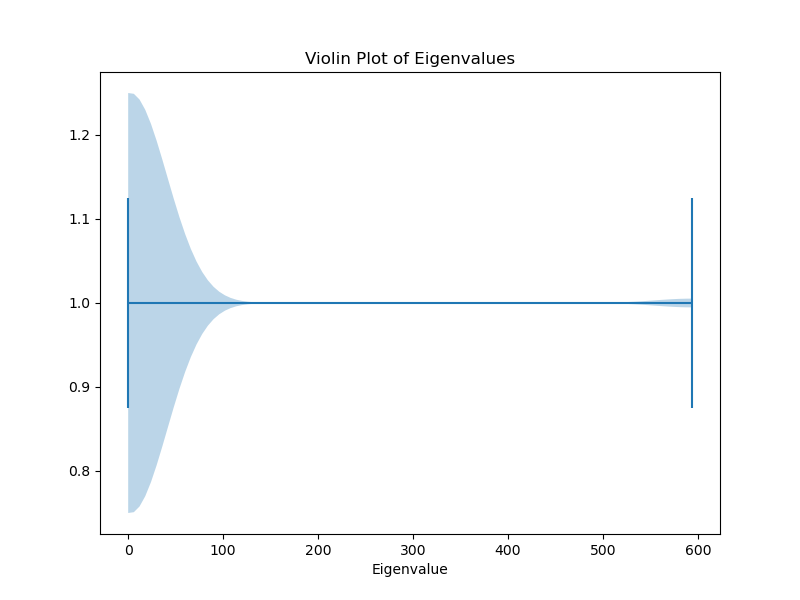

In [29]:
# TODO use the ShellJob node plot_results
display(Image(filename=Path(plot_node.get_remote_workdir()) / figure_file))

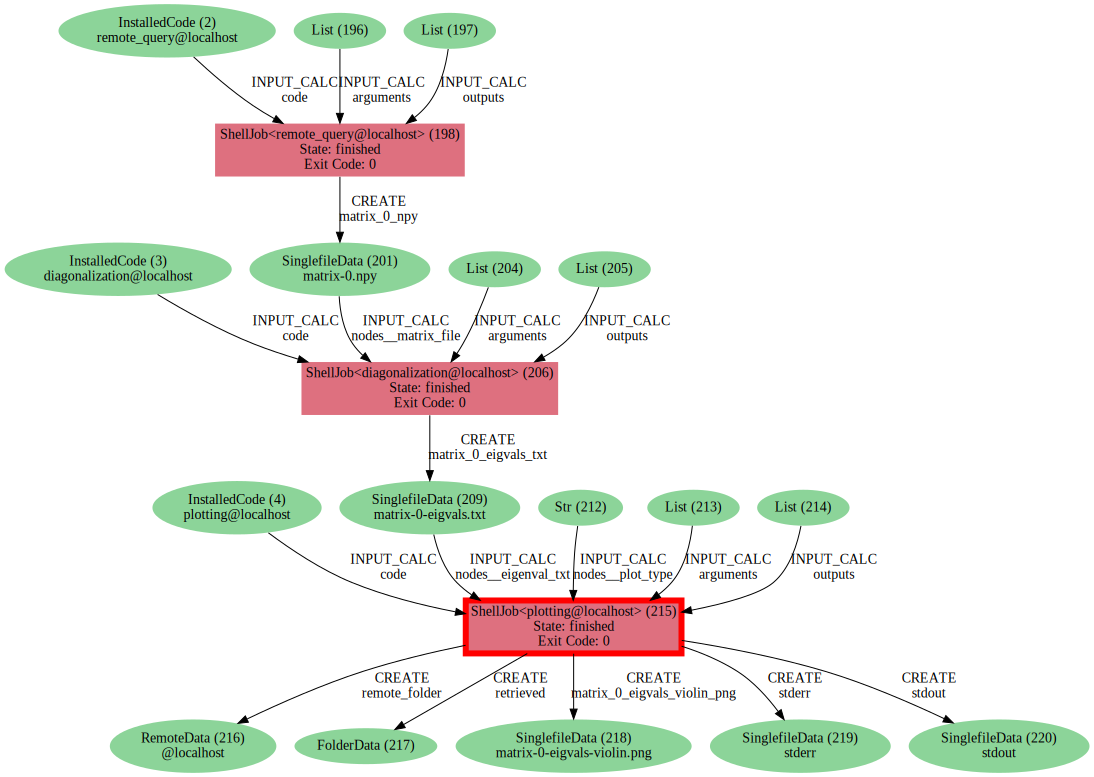

In [30]:
provenance_graph(plot_node)

## Interlude: More `verdi` commands

AiiDA provides many useful `verdi` commands to interact with your processes and data. Some of which are listed in the
[AiiDA cheatsheet](https://aiida.readthedocs.io/projects/aiida-core/en/stable/reference/cheatsheet.html).

As you've seen, `verdi process list -a` shows you all processes (optionally including a time filter with `-p` for *past-days*).

The command:

```shell
verdi calcjob gotocomputer <pk>
```

will take you the working directory of the process with the pk `<pk>` (performing a `cd` command if you run locally, and
ssh-ing into the remote computer if you run remotely).

Alternatively, to extract all the files involved in the execution of a workflow to your local disk, you can run:
```shell
verdi process dump <pk>
```

Remember to replace <pk> with the actual `pk` of your process. E.g. for the `diagonalization` task from above, you will
see that a new folder named `dump-ShellJob<diagonalization@localhost>-<pk>` will be created in the current working
directory 

## Custom parsing of your results

When running your matrix diagonalization, you might not want to only obtain the output file with the eigenvalues, but
actually retrieve them as Python objects, so that you can the directly operate on them. This can be achieved in
`aiida-shell` by attaching a custom parser, like so:

In [31]:
# 1. Query a remote database for data

query_results, query_node = launch_shell_job(
    query_code,
    arguments=f'{db_path} {matrix_pk}',
    outputs=[matrix_file]
)

# Custom parser defined that actually reads the created output file and returns the eigenvalues as an AiiDA data type

def parse_array(self, dirpath: Path) -> dict[str, orm.Data]:
    arr = np.loadtxt(dirpath / self.node.inputs.outputs[0])
    data = orm.ArrayData(arr)
    return {"eigvals": data}

# 2. Run matrix diagonalization with the parser attached

eigvals_file = f'matrix-{matrix_pk}-eigvals.txt'
matrix_file_link_label = ShellParser.format_link_label(matrix_file)

diag_results, diag_node = launch_shell_job(
    diag_code,
    arguments='{matrix_file}',
    nodes={
        'matrix_file': query_results[matrix_file_link_label]
    },
    outputs = [eigvals_file],
    parser=parse_array,  # Parser attached here
)

In [32]:
print(diag_results['eigvals'])
print(diag_results['eigvals'].get_array())

uuid: 8d3d5b32-885d-4b80-96cb-633a99d65289 (pk: 238)
[5.93661571e+02 4.03207045e+00 4.03207045e+00 4.74154885e+00
 4.74154885e+00 3.44346581e+00 3.44346581e+00 3.57871622e+00
 3.57871622e+00 3.23129917e+00 3.23129917e+00 2.82217113e+00
 2.82217113e+00 2.53060338e+00 2.53060338e+00 3.33764827e+00
 3.33764827e+00 2.67697756e+00 2.67697756e+00 2.03203947e+00
 2.03203947e+00 2.39375531e+00 2.39375531e+00 2.34980146e+00
 2.34980146e+00 2.38342140e+00 2.07443748e+00 2.07443748e+00
 1.49205898e+00 1.49205898e+00 1.06237736e+00 1.06237736e+00
 8.71266118e-01 8.71266118e-01 1.05316728e+00 1.05316728e+00
 6.22015017e-01 1.38399912e+00 8.85008894e-01 8.85008894e-01
 7.94168270e-01 7.94168270e-01 4.62879106e-01 4.62879106e-01
 2.43788957e-01 1.88896335e-01 1.14283511e-01 1.14283511e-01
 7.63502395e-03]


We've now seen how we can parse and access the results of our `ShellJob`. This will become important in the next
notebook where we'll start creating more complex workflows. So let's go :fire: